# Load TraCE data
Ref He et al., 2011

In [1]:
import xarray as xr

path='D:/VScode/Last_deglaciation/TraCE_data/'
trace_orb = xr.open_dataset(path + 'b30.00_4kaDVTj.cam2.ncrcat.ann.nc')
trace_allforcing_sat = xr.open_dataset(path+'trace.01-36.22000BP.cam2.TREFHT.22000BP_decavg_400BCE.nc')
trace_allforcing_sic=xr.open_dataset(path+'trace.01-36.22000BP.cam2.ICEFRAC.22000BP_decavg_400BCE.nc')


trace_orb = trace_orb.rename({'TREFHT': 'sat'})
trace_orb = trace_orb.rename({'time': 'age'})
trace_orb['age'] = trace_orb['age'] * -1000
trace_orb['sat'] = trace_orb['sat'] - 273.15 # convert to Celsius

trace_orb_sat = trace_orb[['sat']]
trace_orb_sic = trace_orb[['ICEFRAC']]


trace_allforcing_sat = trace_allforcing_sat.rename({'TREFHT': 'sat'})
trace_allforcing_sat = trace_allforcing_sat.rename({'time': 'age'})
trace_allforcing_sat['age'] = trace_allforcing_sat['age'] * -1000
trace_allforcing_sat['sat'] = trace_allforcing_sat['sat'] - 273.15
trace_allforcing_sat = trace_allforcing_sat[['sat']]


trace_allforcing_sic = trace_allforcing_sic.rename({'time': 'age'})
trace_allforcing_sic['age'] = trace_allforcing_sic['age'] * -1000
trace_allforcing_sic = trace_allforcing_sic[['ICEFRAC']]


6.774467945098877

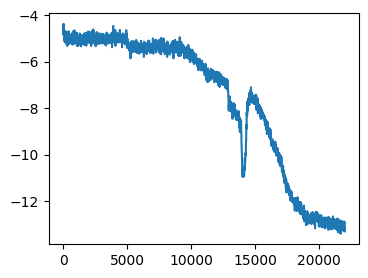

In [ ]:
import xarray as xr

selected_data_at_60s = trace_allforcing_sat.sel(lat=-60, method="nearest")

trace_sat_60s = selected_data_at_60s['sat'].mean(dim='lon')

import matplotlib.pyplot as plt

# Plotting the mean SAT time series at latitude -60 degrees
plt.figure(figsize=(4, 3))  # Set the figure size
plt.plot(trace_sat_60s['age'], trace_sat_60s, label='Mean SAT at -60°')

sat_at_21000 = trace_sat_60s.sel(age=21000, method='nearest').item()
sat_at_11000 = trace_sat_60s.sel(age=11000, method='nearest').item()

# Calculate the difference: later (11000) - former (21000)
difference = sat_at_11000 - sat_at_21000
difference

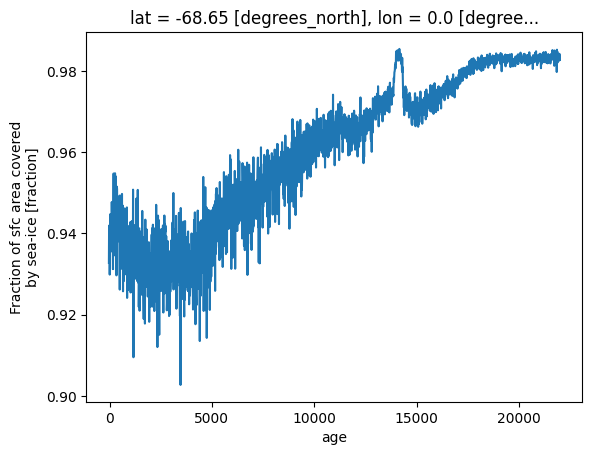

In [ ]:
import matplotlib.pyplot as plt

# Selecting the ICEFRAC data variable and then the specific grid cell
icefrac_data = trace_allforcing_sic['ICEFRAC'].isel(lat=5, lon=0)

# Now plot the data
icefrac_data.plot()

plt.show()


# Calculate the weighted average for the given latitude band for TraCE data

In [3]:
# Function to calculate the weighted average SAT
import numpy as np
import xarray as xr

def calculate_weighted_avg_sat(ds, lat_min=-75, lat_max=-60):
    # Calculate the weight based on latitude
    weight = np.cos(np.deg2rad(ds['lat']))
    weight = xr.where(weight < 0, 0, weight)
    ds['weight'] = weight

    # print the size of the original dataset
    print('size of the original dataset:',ds['sat'].size)
    
    # Select the subset based on latitude
    trace_orb_sat_subset = ds.sel(lat=slice(lat_min, lat_max))
    # PRINT THE SIZE OF THE SUBSET
    print('size of the subset:',trace_orb_sat_subset['sat'].size)

    # Broadcast the weights to the same shape as 'sat'
    weights_broadcasted = trace_orb_sat_subset['weight'].broadcast_like(trace_orb_sat_subset['sat'])

    # Calculate the sum of weighted 'sat' values and the sum of weights
    sum_weighted_sat = (trace_orb_sat_subset['sat'] * weights_broadcasted).sum(dim=['lat', 'lon'])
    sum_weights = weights_broadcasted.sum(dim=['lat', 'lon'])

    # Calculate the weighted average
    weighted_avg_sat = sum_weighted_sat / sum_weights

    return weighted_avg_sat



In [8]:
weighted_avg_orb_sh = calculate_weighted_avg_sat(trace_orb_sat, lat_min=-70, lat_max=-50)
weighted_avg_allforcing_sh = calculate_weighted_avg_sat(trace_allforcing_sat, lat_min=-70, lat_max=-50)

weighted_avg_orb_nh = calculate_weighted_avg_sat(trace_orb_sat, lat_min=50, lat_max=70)
weighted_avg_allforcing_nh = calculate_weighted_avg_sat(trace_allforcing_sat, lat_min=50, lat_max=70)

size of the original dataset: 10156032
size of the subset: 1269504
size of the original dataset: 10156032
size of the subset: 1269504
size of the original dataset: 10156032
size of the subset: 1269504
size of the original dataset: 10156032
size of the subset: 1269504


In [13]:
weighted_avg_orb_sh

<xarray.DataArray (age: 2204)>
array([-10.92667327, -11.01567604, -10.97622441, ...,  -9.93815755,
       -10.10832271, -10.03293567])
Coordinates:
  * age      (age) float64 2.2e+04 2.199e+04 2.198e+04 ... -10.0 -20.0 -30.0

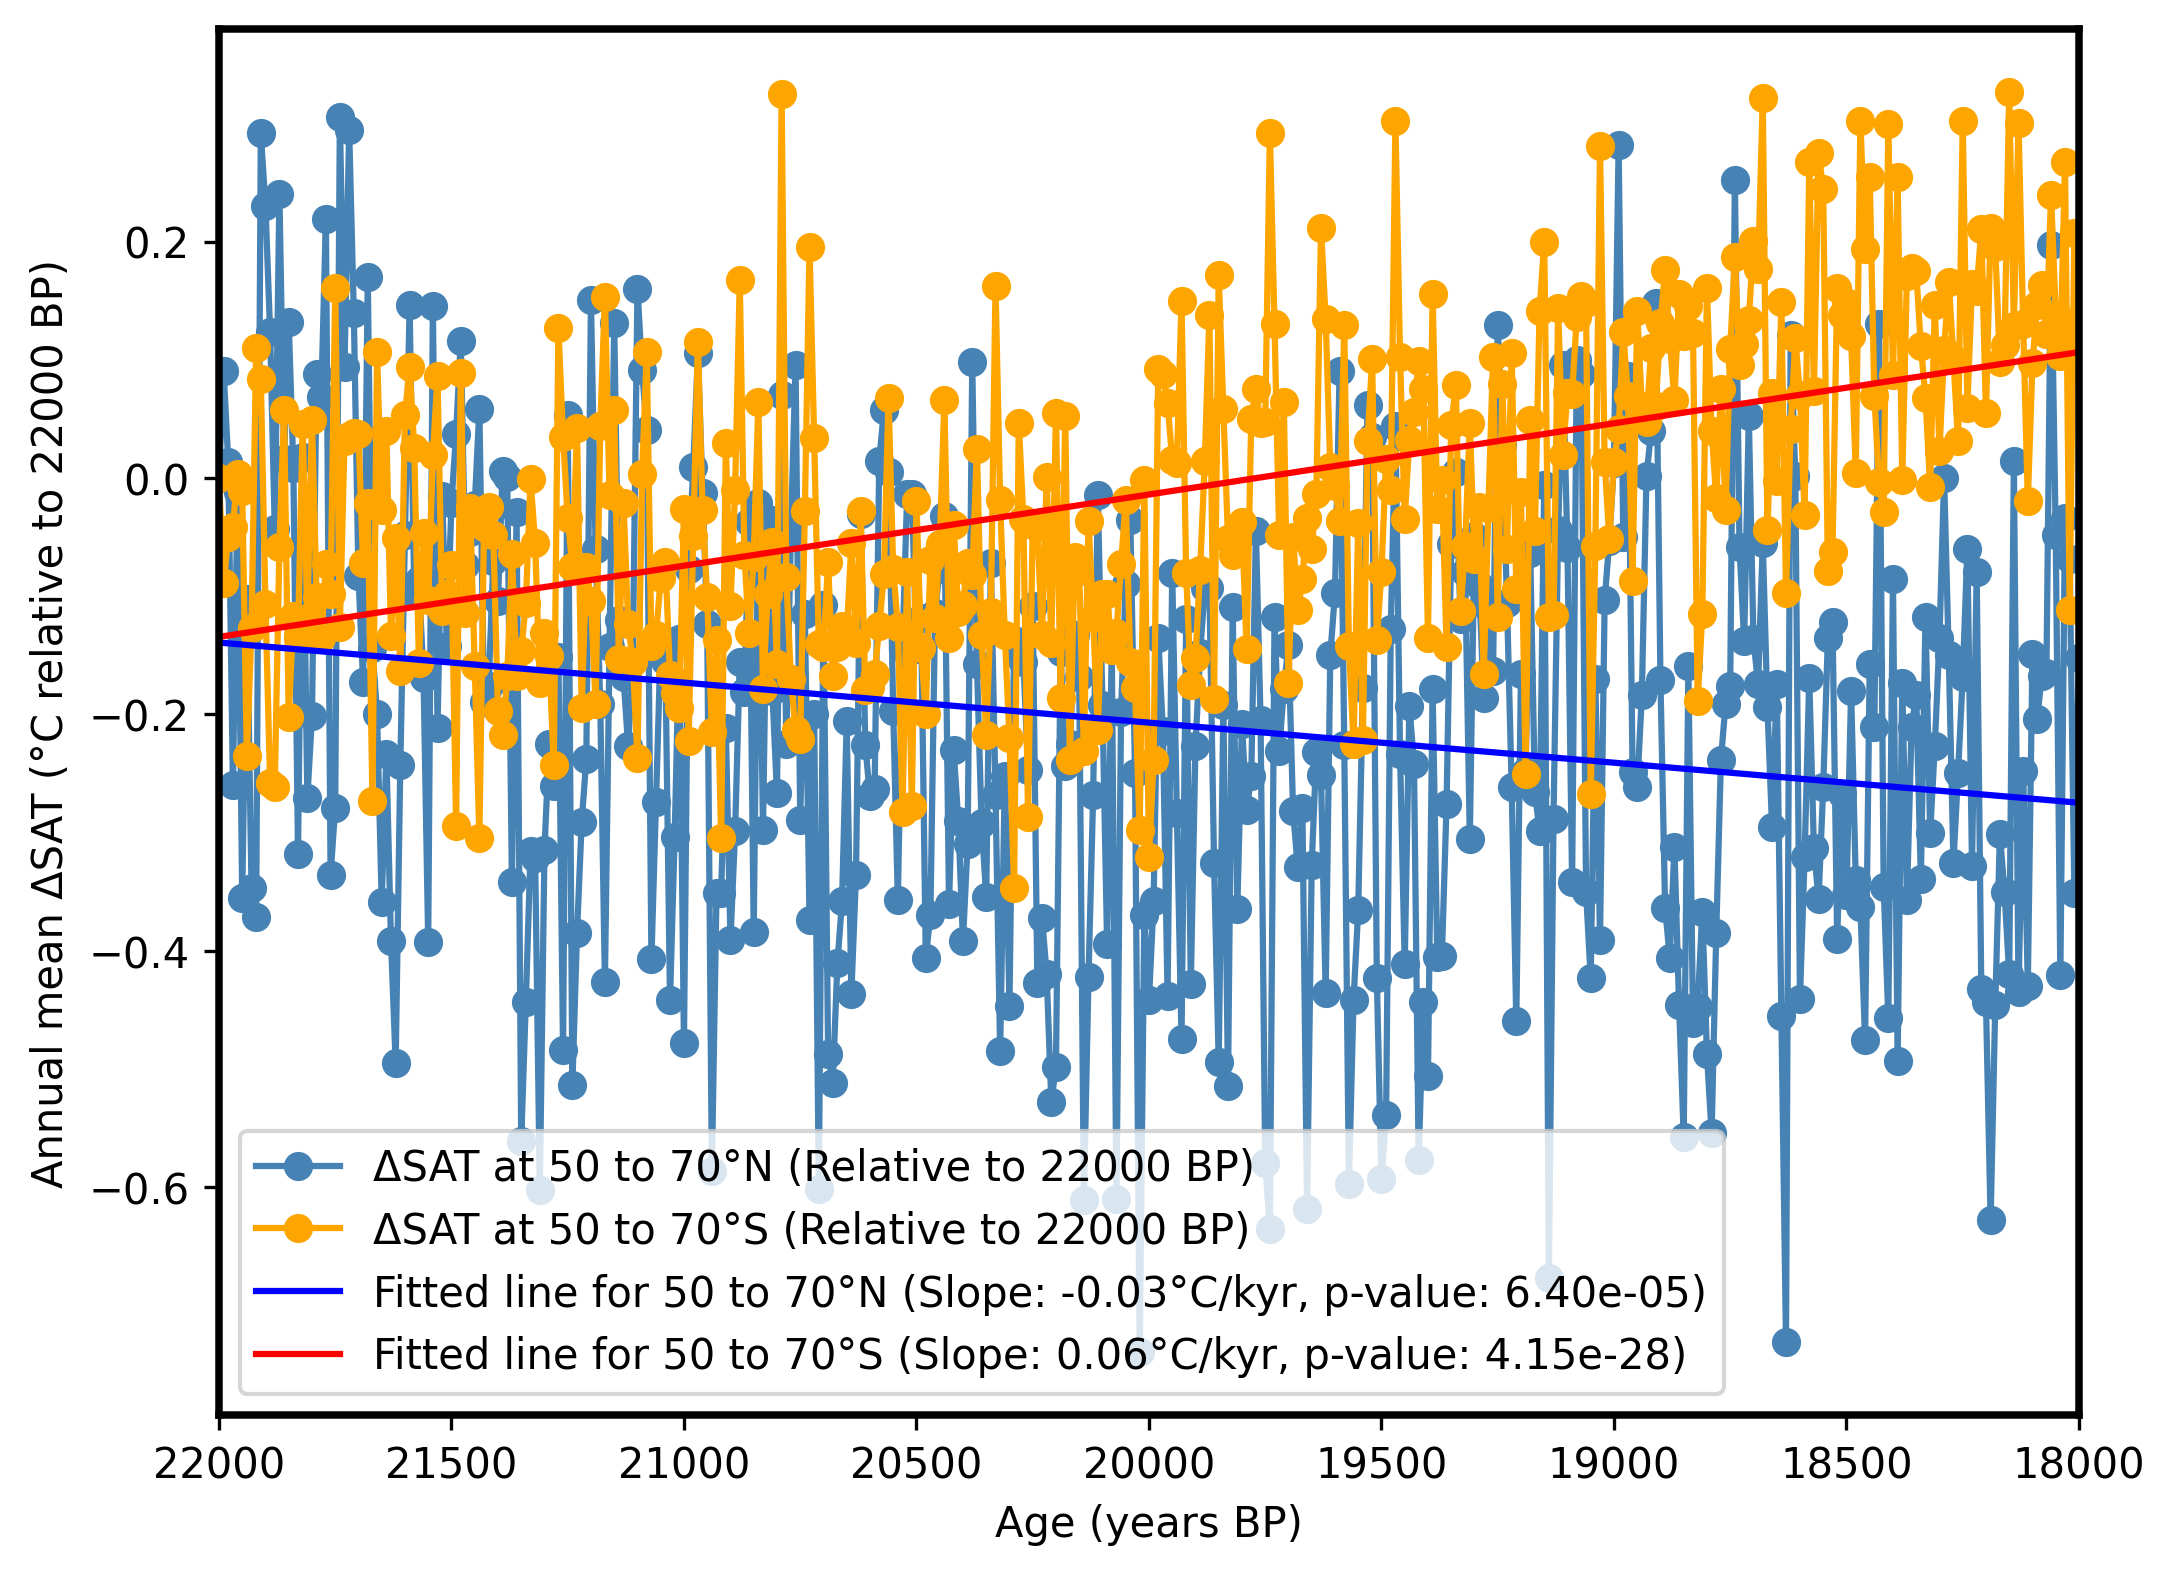

((0.06024576547991482, 4.146964624272575e-28, -0.24098306191965935),
 (-0.033890617410916424, 6.403596946229066e-05, 0.1355624696436657))

In [ ]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Assuming weighted_avg_orb and weighted_avg_orb_nh are xarray DataArray objects
# Ensure these objects are correctly defined before this code snippet
weighted_avg_orb=weighted_avg_orb_sh
weighted_avg_allforcing=weighted_avg_allforcing_sh

# Crop the data between 19 to 22 kyr before fitting the line and plotting
weighted_avg_orb = weighted_avg_orb.sel(age=slice(22000, 18000))
weighted_avg_orb_nh = weighted_avg_orb_nh.sel(age=slice(22000, 18000))

age_orb = weighted_avg_orb['age'].values
temp_orb = weighted_avg_orb.values
temp_orb_nh = weighted_avg_orb_nh.values

# Adjust temperatures relative to their value at 22000 BP
temp_orb_baseline = temp_orb[np.argmin(np.abs(age_orb - 22000))]
temp_orb_nh_baseline = temp_orb_nh[np.argmin(np.abs(age_orb - 22000))]

temp_orb_relative = temp_orb - temp_orb_baseline
temp_orb_nh_relative = temp_orb_nh - temp_orb_nh_baseline

# Fit a straight line to the adjusted datasets
slope_orb, intercept_orb, r_value_orb, p_value_orb, std_err_orb = stats.linregress(age_orb, temp_orb_relative)
slope_orb_nh, intercept_orb_nh, r_value_orb_nh, p_value_orb_nh, std_err_orb_nh = stats.linregress(age_orb, temp_orb_nh_relative)

# Calculate the y-values based on the fitted line to the adjusted data
fitted_y_orb = slope_orb * age_orb + intercept_orb
fitted_y_orb_nh = slope_orb_nh * age_orb + intercept_orb_nh

# Plotting
plt.figure(figsize=(8, 6),dpi=300)  # Adjusted for better visibility

# Original data points adjusted relative to their values at 22000 BP
plt.plot(age_orb, temp_orb_nh_relative, 'o-', color='steelblue', label='ΔSAT at 50 to 70°N (Relative to 22000 BP)')
plt.plot(age_orb, temp_orb_relative, 'o-', color='orange', label='ΔSAT at 50 to 70°S (Relative to 22000 BP)')

# Fitted lines for the adjusted data
plt.plot(age_orb, fitted_y_orb_nh, 'b-', label=f'Fitted line for 50 to 70°N (Slope: {slope_orb_nh*-1000:.2f}°C/kyr, p-value: {p_value_orb_nh:.2e})')
plt.plot(age_orb, fitted_y_orb, 'r-', label=f'Fitted line for 50 to 70°S (Slope: {slope_orb*-1000:.2f}°C/kyr, p-value: {p_value_orb:.2e})')

# Enhance plot appearance
plt.gca().spines['top'].set_linewidth(1.8)
plt.gca().spines['right'].set_linewidth(1.8)
plt.gca().spines['bottom'].set_linewidth(1.8)
plt.gca().spines['left'].set_linewidth(1.8)

plt.xlabel('Age (years BP)')
plt.ylabel('Annual mean ΔSAT (°C relative to 22000 BP)')
plt.legend()
plt.xlim(18000, 22000)
# set y lim
# plt.ylim(-1.1, 0.4)
plt.gca().invert_xaxis()  # Invert x-axis to have older ages on the right
plt.show()

# Return slope in °C/kyr, p-value, and temperature difference from 22 to 19 kyr for both datasets
(slope_orb*-1000, p_value_orb, fitted_y_orb[0] - fitted_y_orb[-1]), (slope_orb_nh*-1000, p_value_orb_nh, fitted_y_orb_nh[0] - fitted_y_orb_nh[-1])


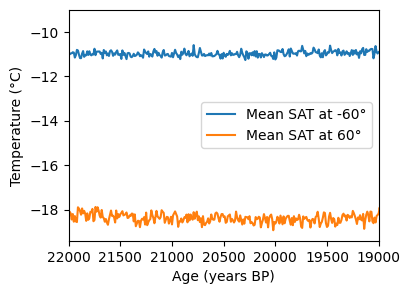

In [ ]:
# plot the weighted_avg_orb and weighted_avg_orb_nh

import matplotlib.pyplot as plt

# Plotting the mean SAT time series at latitude -60 degrees
plt.figure(figsize=(4, 3))  # Set the figure size
plt.plot(weighted_avg_orb['age'], weighted_avg_orb, label='Mean SAT at -60°')
plt.plot(weighted_avg_orb_nh['age'], weighted_avg_orb_nh, label='Mean SAT at 60°')
plt.xlabel('Age (years BP)')
plt.ylabel('Temperature (°C)')
plt.legend()
# se the xlimt
plt.xlim(19000, 22000)
# invert the x axis
plt.gca().invert_xaxis()


# Calculate sea ice area forTraCE

In [5]:
import xarray as xr
import numpy as np
import pickle

def calculate_seaice_area(ds_seaice, variable_name='sic',lat_min=-90,lat_max=0):    
    # Subset dataset for latitude from -90 to 0
    ds_seaice_subset = ds_seaice.sel(lat=slice(lat_min, lat_max))

    # Constants
    R = 6371  # Earth's radius in km
    delta_theta = 2.5 / 180 * np.pi  # 2.5 degree in radians

    # Convert latitude values to radians and compute latitudinal boundaries
    lat_radians = np.radians(ds_seaice_subset['lat'].values)
    lat_boundaries = (lat_radians[:-1] + lat_radians[1:]) / 2

    # area of each grid, 
    # Ref: https://www.johndcook.com/blog/2023/02/21/sphere-grid-area/#:~:text=Area%20of%20latitude%2Flongitude%20grid&text=A%20%3D%20%CF%80%20R%C2%B2%20(sin%20%CF%86,1%20%E2%88%92%20%CE%B82)%2F180.
    A = R**2 * delta_theta * (np.sin(lat_boundaries[1:]) - np.sin(lat_boundaries[:-1]))
    A_center_lats = ds_seaice_subset['lat'].values[1:-1]

    # Reduce dataset size
    ds_seaice_subset_reduced = ds_seaice_subset.isel(lat=slice(1, -1))

    # Create an xarray DataArray for A
    A_xr = xr.DataArray(A, dims=["lat"], coords={"lat": A_center_lats})

    # Multiply sic data with A
    sic = ds_seaice_subset_reduced[variable_name]
    sic_area = sic * A_xr

    # Sum up the resulting product
    LGMR_sic_area = sic_area.sum(dim=["lat", "lon"]).values / 1e6
    # print('LGMR_sic_area:', LGMR_sic_area.shape)

    # Add age to LGMR_sic_area
    LGMR_sic_area = np.column_stack((ds_seaice_subset_reduced['age'].values, LGMR_sic_area))

    return LGMR_sic_area


In [ ]:

asice_trace_orb=calculate_seaice_area(trace_orb_sic, variable_name='ICEFRAC')
asice_trace_allforcing=calculate_seaice_area(trace_allforcing_sic, variable_name='ICEFRAC') 

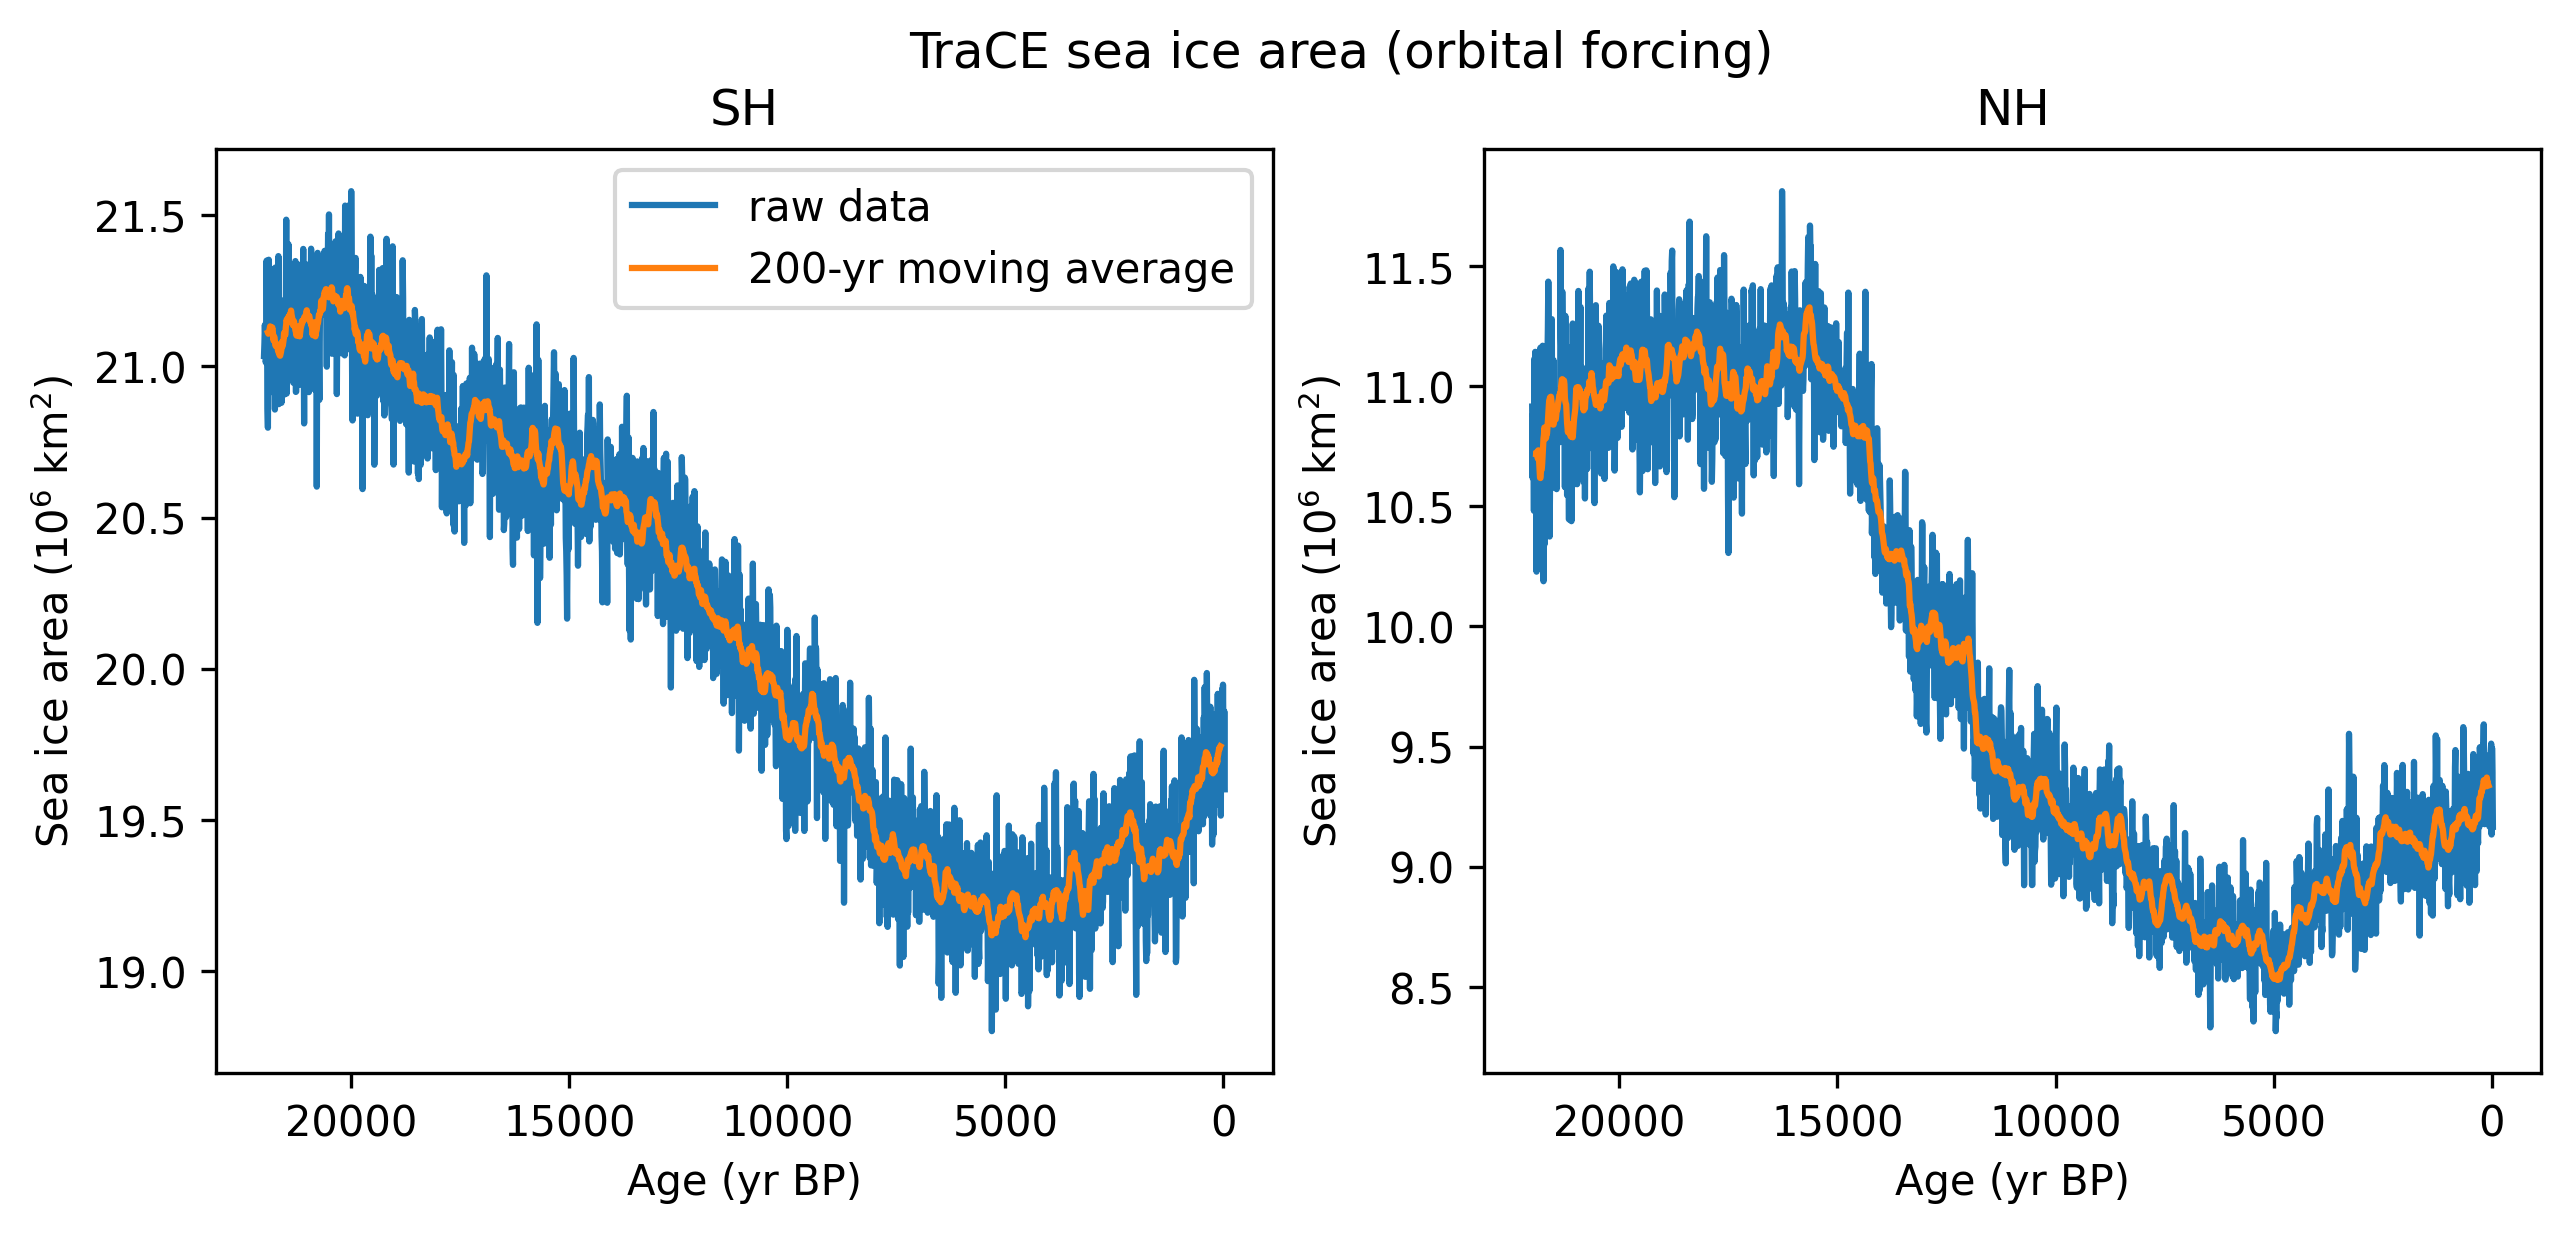

In [ ]:
asice_trace_orb_sh = calculate_seaice_area(trace_orb_sic, variable_name='ICEFRAC', lat_min=-90, lat_max=0)
asice_trace_allforcing_sh = calculate_seaice_area(trace_allforcing_sic, variable_name='ICEFRAC', lat_min=-90, lat_max=0)

asice_trace_orb_nh = calculate_seaice_area(trace_orb_sic, variable_name='ICEFRAC', lat_min=0, lat_max=90)
asice_trace_allforcing_nh = calculate_seaice_area(trace_allforcing_sic, variable_name='ICEFRAC', lat_min=0, lat_max=90)

# plot asice_trace_orb_sh and asice_trace_orb_nh side by side

# Smooth the data with a 10-point moving average
import numpy as np
def moving_average(data, points=10):
    return np.convolve(data, np.ones(points)/points, mode='valid')

# plot asice_trace_orb_sh and asice_trace_orb_nh side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4),dpi=300)
fig.suptitle('TraCE sea ice area (orbital forcing)')

smoothing_len=20

# Apply the moving average to your data
smoothed_asice_trace_orb_sh = moving_average(asice_trace_orb_sh[:, 1], smoothing_len)
smoothed_asice_trace_orb_nh = moving_average(asice_trace_orb_nh[:, 1], smoothing_len)

# Since the moving average reduces the length of the data, adjust the x-axis data accordingly
adjusted_x_sh = asice_trace_orb_sh[9:-10, 0]  # Adjusting for a 10-point average
adjusted_x_nh = asice_trace_orb_nh[9:-10, 0]  # Same here

ax1.plot(asice_trace_orb_sh[:, 0], asice_trace_orb_sh[:, 1], label='raw data')
ax1.plot(adjusted_x_sh, smoothed_asice_trace_orb_sh,label='200-yr moving average')
ax1.set_title('SH')
ax1.set_xlabel('Age (yr BP)')
ax1.set_ylabel('Sea ice area ($10^6$ km$^2$)')
ax1.legend()
ax1.invert_xaxis()

ax2.plot(asice_trace_orb_nh[:, 0], asice_trace_orb_nh[:, 1], label='NH')
ax2.plot(adjusted_x_nh, smoothed_asice_trace_orb_nh)
ax2.set_title('NH')
ax2.set_xlabel('Age (yr BP)')
ax2.set_ylabel('Sea ice area ($10^6$ km$^2$)')
ax2.invert_xaxis()

plt.show()


In [6]:
asice_trace_orb_sh = calculate_seaice_area(trace_orb_sic, variable_name='ICEFRAC', lat_min=-90, lat_max=0)
asice_trace_allforcing_sh = calculate_seaice_area(trace_allforcing_sic, variable_name='ICEFRAC', lat_min=-90, lat_max=0)

asice_trace_orb_nh = calculate_seaice_area(trace_orb_sic, variable_name='ICEFRAC', lat_min=0, lat_max=90)
asice_trace_allforcing_nh = calculate_seaice_area(trace_allforcing_sic, variable_name='ICEFRAC', lat_min=0, lat_max=90)

In [11]:
asice_trace_orb_sh.shape

(2204, 2)

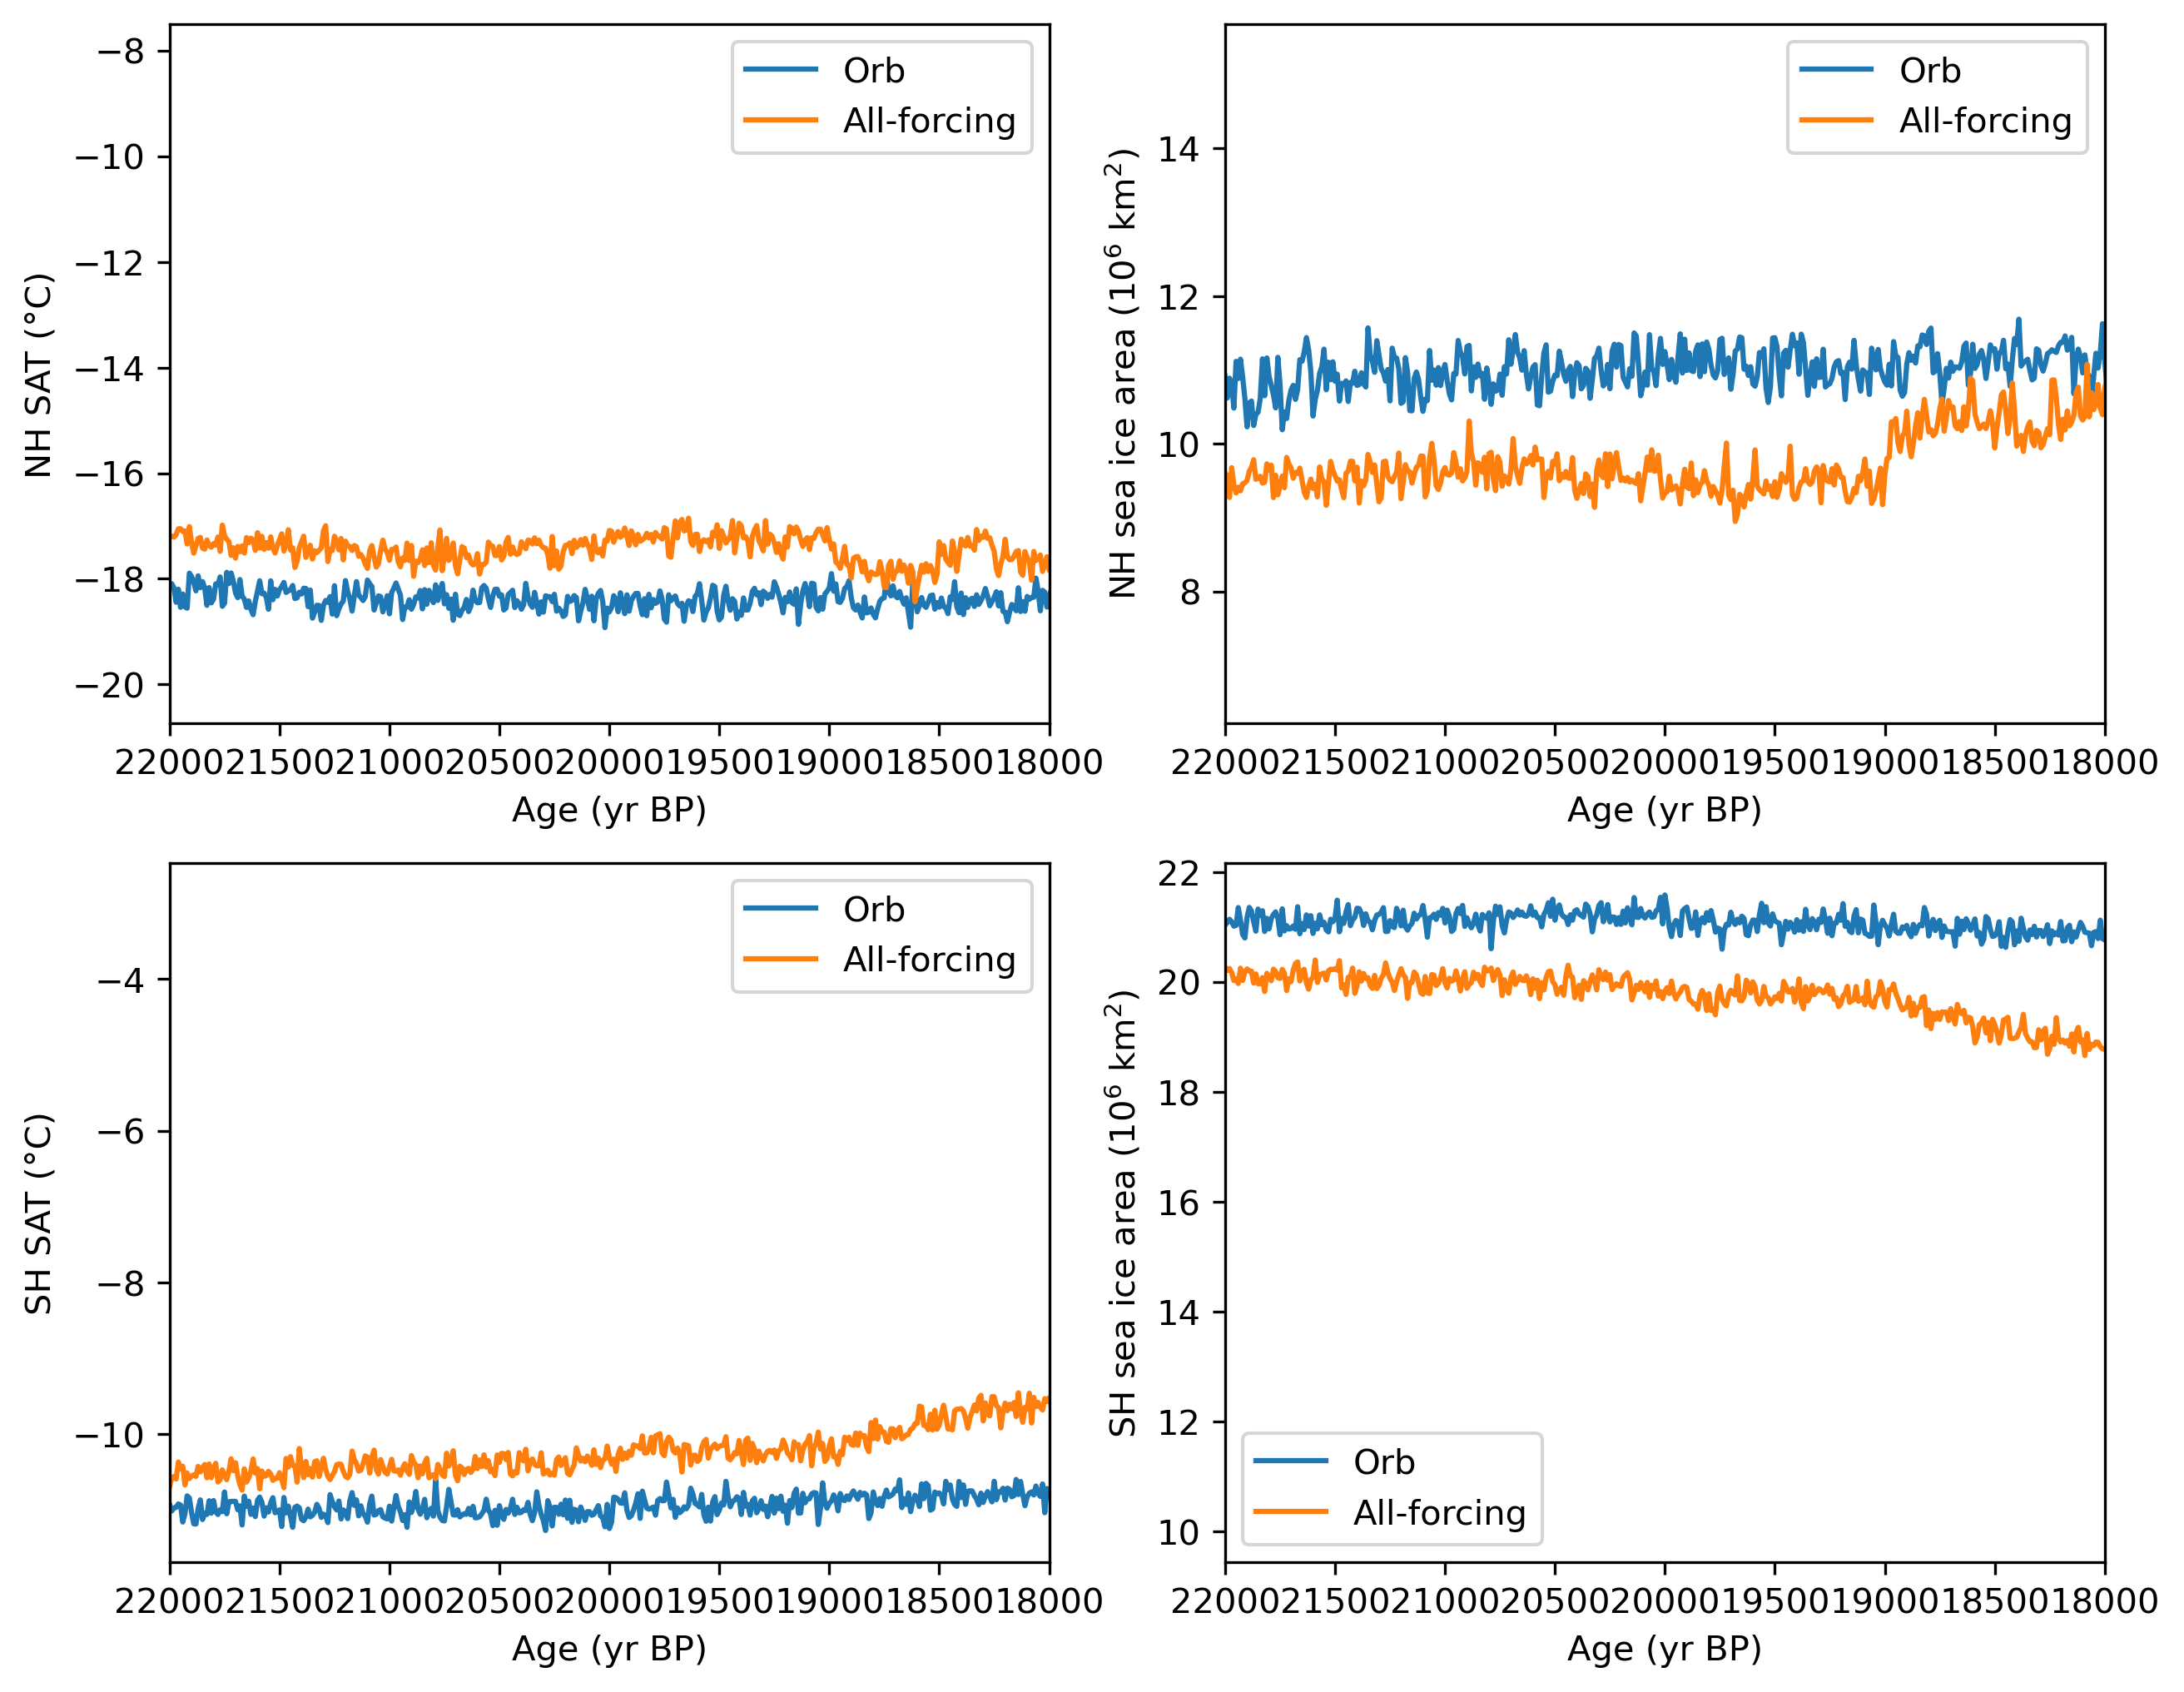

In [22]:
# create a figure with 2 by 2 subplots
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10, 8),dpi=300)

age_sat = weighted_avg_orb['age'].values
age_sic = asice_trace_orb_sh[:, 0]

ax=axs[0,0]
#plot sat of NH, both orb and allforcing
ax.plot(age_sat, weighted_avg_orb_nh, label='Orb')
ax.plot(age_sat, weighted_avg_allforcing_nh, label='All-forcing')
# set x limit
ax.set_xlim(22000, 18000)
ax.set_xlabel('Age (yr BP)')
ax.set_ylabel('NH SAT (°C)')
ax.legend()

ax=axs[0,1]
# plot the sic of NH, both orb and allforcing
ax.plot(age_sic, asice_trace_orb_nh[:, 1], label='Orb')
ax.plot(age_sic, asice_trace_allforcing_nh[:, 1], label='All-forcing')
ax.set_xlim(22000, 18000)
ax.set_xlabel('Age (yr BP)')
ax.set_ylabel('NH sea ice area ($10^6$ km$^2$)')
ax.legend()

ax=axs[1,0]
# plot the sat of SH, both orb and allforcing
ax.plot(age_sat, weighted_avg_orb_sh, label='Orb')
ax.plot(age_sat, weighted_avg_allforcing_sh, label='All-forcing')
ax.set_xlim(22000, 18000)
ax.set_xlabel('Age (yr BP)')
ax.set_ylabel('SH SAT (°C)')
ax.legend()

ax=axs[1,1]
# plot the sic of SH, both orb and allforcing
ax.plot(age_sic, asice_trace_orb_sh[:, 1], label='Orb')
ax.plot(age_sic, asice_trace_allforcing_sh[:, 1], label='All-forcing')
ax.set_xlim(22000, 18000)
ax.set_xlabel('Age (yr BP)')
ax.set_ylabel('SH sea ice area ($10^6$ km$^2$)')
ax.legend()